In [1]:
from forecast_engine import DataLoader
from aquarel import load_theme  # lightweight templating engine and wrapper around Matplotlibs' rcparams
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

In [2]:
import getpass
import os
export_username = "ts" # Only save plots to dropbox on my machine
def save_plot(plot, filename):
    username = getpass.getuser()
    filepath = "/Users/ts/Library/CloudStorage/Dropbox/Apps/Overleaf/Dissertation Oxford/Figures"
    filename += ".eps"
    if username == export_username:
        plot.savefig(os.path.join(filepath, filename), format='eps') # Save as EPS

In [3]:
# Load Merged data
data_loader = DataLoader("data/merged")
data_loader.load_data()
load_forecast = data_loader.data['load_forecast']
wind_solar_forecast = data_loader.data['wind_solar_forecast']
day_ahead_prices = data_loader.data['day_ahead_prices']
coal_gas = data_loader.data['coal_gas']
generation_forecast = data_loader.data['generation_forecast']

# Prepare the data
countries = day_ahead_prices.columns
n_countries = len(countries)

Using installed capacity data from 2019


In [4]:
# Custom color palette
col_pal = [
    '#FF3B30',  # Red
    '#FF9500',  # Orange
    '#FFCC00',  # Yellow
    '#34C759',  # Green
    '#00C7BE',  # Mint
    '#30B0C7',  # Teal
    '#32ADE6',  # Cyan
    '#007AFF',  # Blue
    '#5856D6',  # Indigo
    '#AF52DE',  # Purple
    '#FF6483',  # Pink
    '#A2845E'   # Brown
]
# Set up the plot theme
theme = (
    load_theme("boxy_light")
    .set_overrides({'axes.prop_cycle': plt.cycler(color=col_pal)})
)
theme.apply()

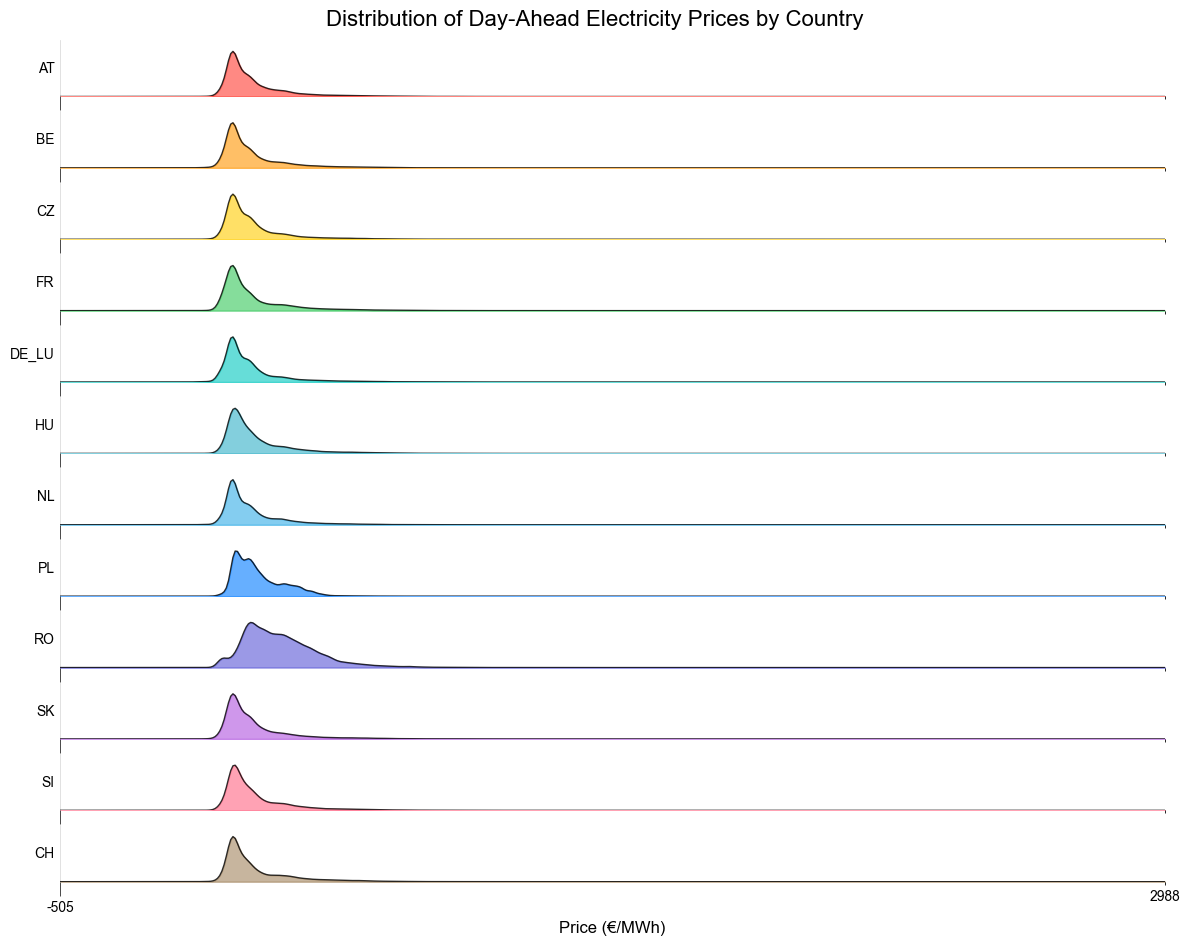

<Figure size 640x480 with 0 Axes>

In [5]:
# Set up the plot
fig, axes = plt.subplots(n_countries, 1, figsize=(12, 0.8*n_countries), sharex=True)
fig.subplots_adjust(hspace=0)  # Remove vertical space between subplots

# Set x-axis range
x_min, x_max = (day_ahead_prices.min().min() - 5), day_ahead_prices.max().max()

for i, (country, ax) in enumerate(zip(countries, axes)):
    data = day_ahead_prices[country].dropna()
    density = gaussian_kde(data)  # Calculate kernel density estimation
    xs = np.linspace(x_min, x_max, 500)
    ys = density(xs)
    ys = 0.8 * ys / ys.max()  # Normalize ys to max of 0.8 to leave space for labels
    ax.fill_between(xs, ys, alpha=0.6, color=col_pal[i % len(col_pal)])  # Plot the KDE
    ax.plot(xs, ys, color='black', alpha=0.8, linewidth=1)
    ax.set_ylabel(country, rotation=0, ha='right', va='center') # Set country name as y-axis label
    ax.set_yticks([]) # Remove y-axis ticks
    ax.set_ylim(0, 1)  # Set y-limit to 1 for all subplots
    ax.set_xticks([0])  # Add a tick and label at 0 on the x-axis
    ax.set_xticklabels(['0'])
    # add tick at x_min
    ax.set_xticks([x_min])
    ax.set_xticklabels([f'{x_min:.0f}'])
    # add tick at x_max
    ax.set_xticks([x_max], minor=True)
    ax.set_xticklabels([f'{x_max:.0f}'], minor=True)
    for spine in ax.spines.values():
        spine.set_visible(False)  # Remove the box around the subplot

# Set overall title and x-axis label
fig.suptitle('Distribution of Day-Ahead Electricity Prices by Country', fontsize=16)
axes[-1].set_xlabel('Price (€/MWh)', fontsize=12)
plt.xlim(x_min, x_max)  # Set x-axis limits
plt.tight_layout()
theme.apply_transforms()

plt.show()
save_plot(plt, "day_ahead_prices_distribution")

In [6]:
def plot_missingness(data, title):
    """
    Plots the missingness of data for each country over time.

    Parameters:
    data (pd.DataFrame): DataFrame containing the data with countries as columns and dates as index.
    title (str): Title of the plot.

    Returns:
    matplotlib.figure.Figure: The figure object containing the plot.
    """
    countries = data.columns
    dates = data.index

    fig, ax = plt.subplots(figsize=(15, 10))

    for i, country in enumerate(countries):
        missing = data[country].isna()
        
        # Plot non-missing data
        ax.scatter(dates[~missing], [i] * (~missing).sum(), color='#e5e5ea', 
                   s=1, marker='|', linewidths=0.5)
        
        # Plot missing data
        ax.scatter(dates[missing], [i] * missing.sum(), color='red', 
                   s=10, marker='|', linewidths=0.5)

    ax.set_yticks(range(len(countries)))
    ax.set_yticklabels(countries)
    ax.set_xlabel('Date')
    ax.set_title(title)

    # Improve x-axis labeling
    ax.xaxis_date()
    fig.autofmt_xdate()  # Rotate and align the tick labels

    plt.tight_layout()
    return fig

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


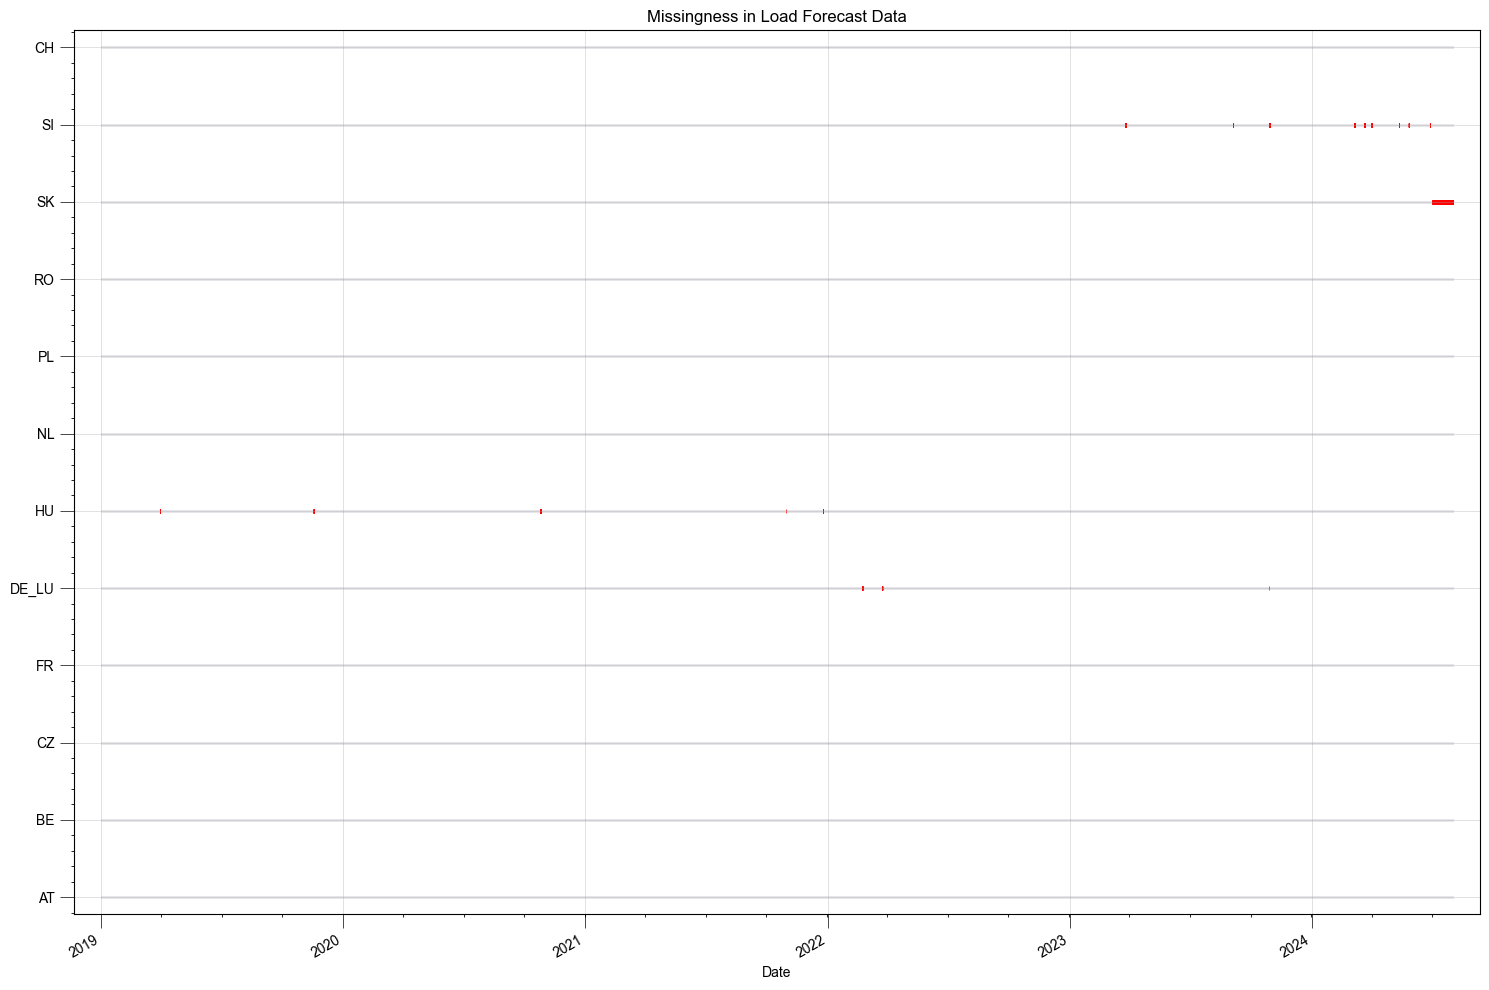

In [7]:
# Use the function to plot missingness for load_forecast
fig_load_forecast = plot_missingness(load_forecast, 'Missingness in Load Forecast Data')
save_plot(fig_load_forecast, "missingness_load_forecast")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


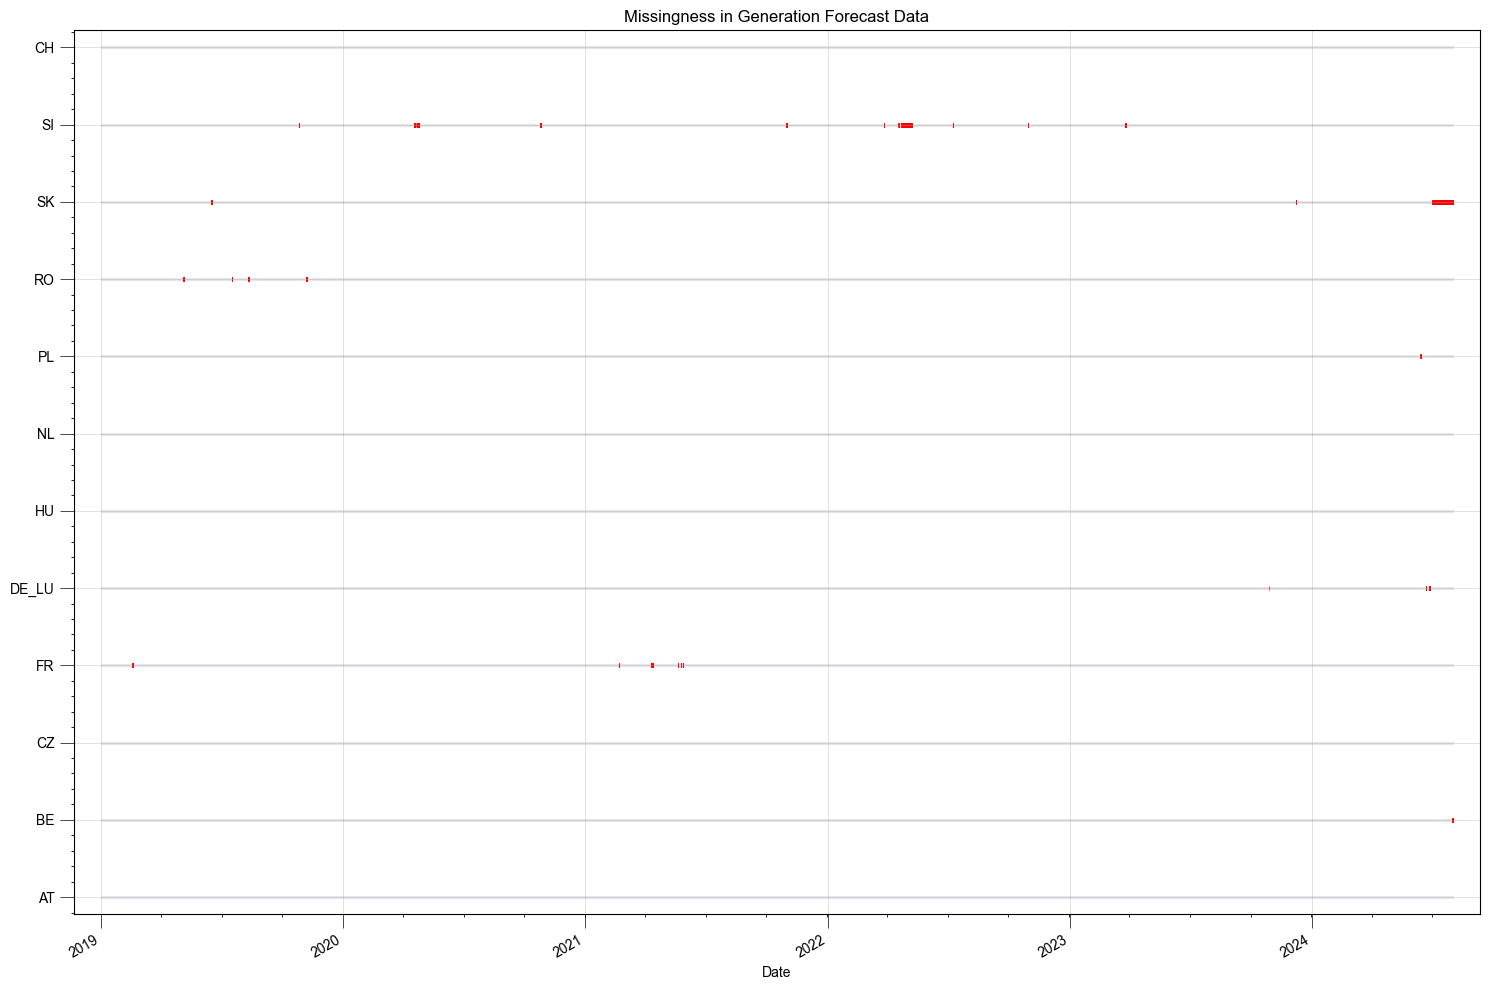

In [8]:
# Use the function to plot missingness for generation_forecast
fig_gen_forecast = plot_missingness(generation_forecast, 'Missingness in Generation Forecast Data')
save_plot(fig_gen_forecast, "missingness_generation_forecast")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


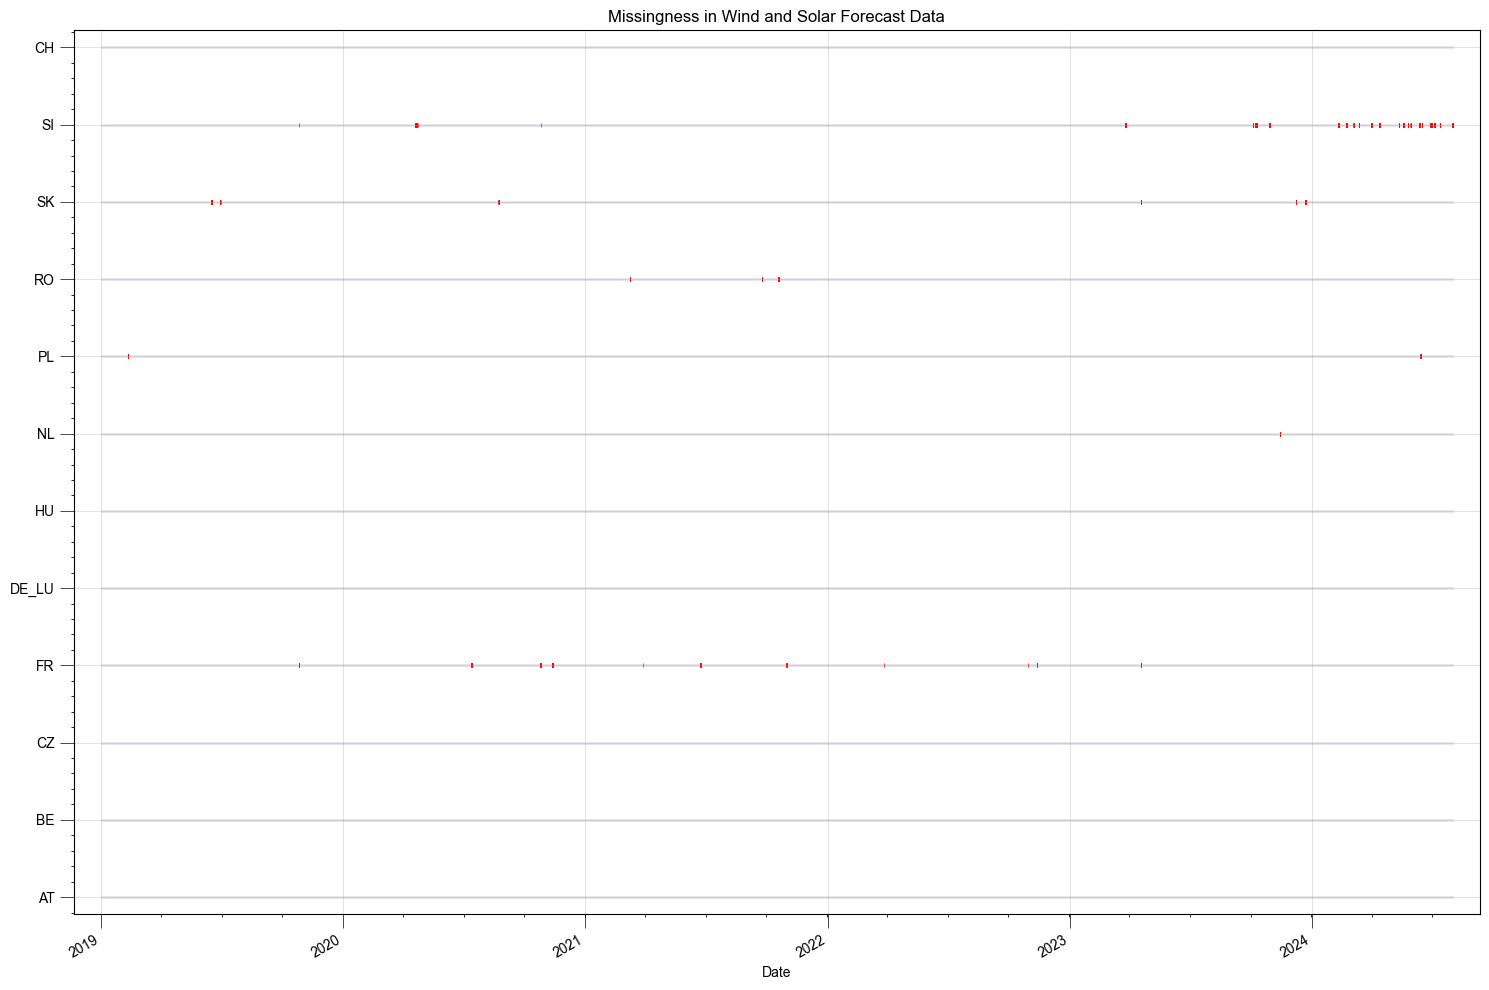

In [9]:
# Use the function to plot missingness for wind_solar_forecast
fig_wind_solar_forecast = plot_missingness(wind_solar_forecast, 'Missingness in Wind and Solar Forecast Data')
save_plot(fig_wind_solar_forecast, "missingness_wind_solar_forecast")

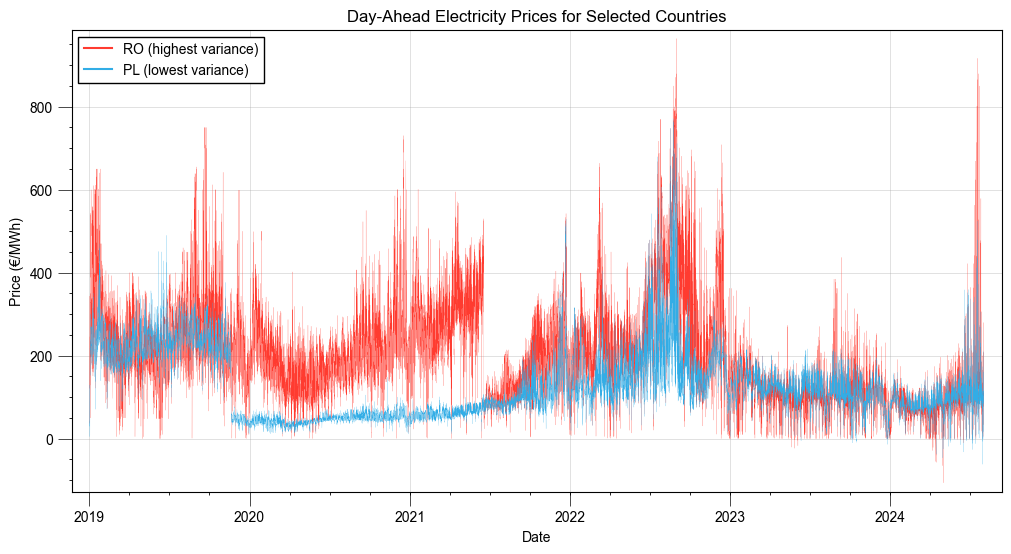

<Figure size 640x480 with 0 Axes>

In [10]:
from matplotlib.lines import Line2D

colors = [col_pal[0], col_pal[6]]

# Define custom labels
custom_labels = [" (highest variance)", " (lowest variance)"]

variance = day_ahead_prices.var()
highvar_country = variance.idxmax()
lowvar_country = variance.idxmin()
countries = [highvar_country, lowvar_country]
plt.figure(figsize=(12, 6))

for i, country in enumerate(countries):
    plt.plot(day_ahead_prices.index, day_ahead_prices[country], label=country + custom_labels[i], linewidth=0.1, color=colors[i])

# Create custom legend handles with default linewidth and custom labels
legend_handles = [Line2D([0], [0], color=colors[i], label=country + custom_labels[i]) for i, country in enumerate(countries)]

plt.title('Day-Ahead Electricity Prices for Selected Countries')
plt.xlabel('Date')
plt.ylabel('Price (€/MWh)')
plt.legend(handles=legend_handles)
theme.apply_transforms()
plt.show()
save_plot(plt, "day_ahead_prices_variance")

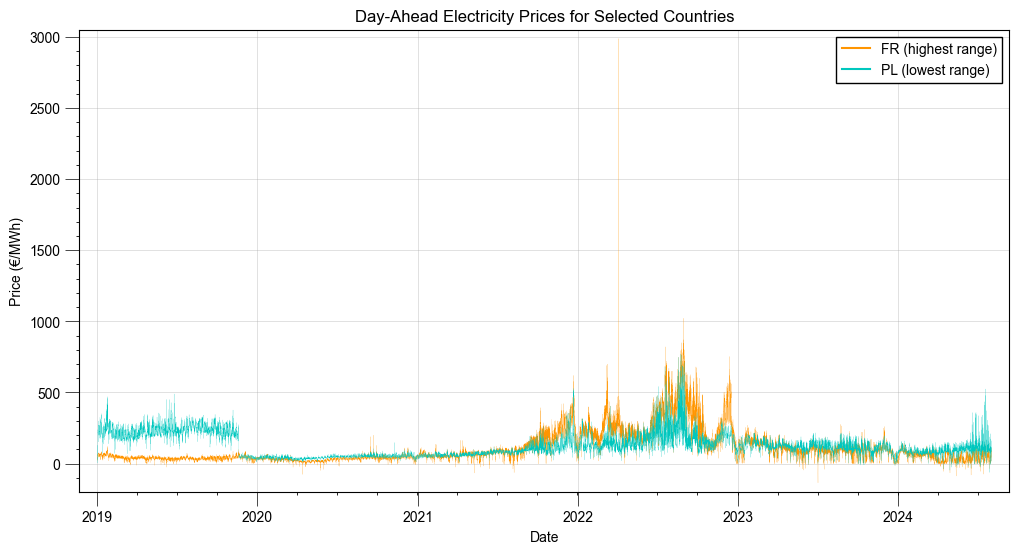

<Figure size 640x480 with 0 Axes>

In [11]:
from matplotlib.lines import Line2D

# Define the colors
colors = [col_pal[1], col_pal[4]]

# Define custom labels
custom_labels = [" (highest range)", " (lowest range)"]

# Calculate the range for each country
ranges = day_ahead_prices.max() - day_ahead_prices.min()
highrange_country = ranges.idxmax()
lowrange_country = ranges.idxmin()
countries = [highrange_country, lowrange_country]
plt.figure(figsize=(12, 6))

for i, country in enumerate(countries):
    plt.plot(day_ahead_prices.index, day_ahead_prices[country], label=country + custom_labels[i], linewidth=0.1, color=colors[i])

# Create custom legend handles with default linewidth and custom labels
legend_handles = [Line2D([0], [0], color=colors[i], label=country + custom_labels[i]) for i, country in enumerate(countries)]

plt.title('Day-Ahead Electricity Prices for Selected Countries')
plt.xlabel('Date')
plt.ylabel('Price (€/MWh)')
plt.legend(handles=legend_handles)
theme.apply_transforms()
plt.show()
save_plot(plt, "day_ahead_prices_range")

In [11]:
# Create the subplots, arranging them in a 1x3 grid (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Assuming fig1, fig2, fig3 are the figures you want to combine
# You need to access their respective axes objects and plot again on the new subplots

# Example plot1 on the first subplot
axs[0].plot(data1_x, data1_y)  # Replace with your plot code
axs[0].set_title('Plot 1')

# Example plot2 on the second subplot
axs[1].plot(data2_x, data2_y)  # Replace with your plot code
axs[1].set_title('Plot 2')

# Example plot3 on the third subplot
axs[2].plot(data3_x, data3_y)  # Replace with your plot code
axs[2].set_title('Plot 3')

# Adjust the layout
plt.tight_layout()

# Show the combined figure
plt.show()

In [36]:
def plot_combined_missingness(title):
    """
    Plots the missingness of data for each country over time for three different datasets.

    Parameters:
    load_forecast (pd.DataFrame): DataFrame containing the load forecast data.
    generation_forecast (pd.DataFrame): DataFrame containing the generation forecast data.
    wind_solar_forecast (pd.DataFrame): DataFrame containing the wind and solar forecast data.
    title (str): Title of the plot.

    Returns:
    matplotlib.figure.Figure: The figure object containing the plot.
    """
    load_forecast = data_loader.data['load_forecast']
    generation_forecast = data_loader.data['generation_forecast']
    wind_solar_forecast = data_loader.data['wind_solar_forecast']
    countries = load_forecast.columns
    dates = load_forecast.index

    fig, ax = plt.subplots(figsize=(15, 10))

    for i, country in enumerate(countries):
        load_missing = load_forecast[country].isna()
        gen_missing = generation_forecast[country].isna()
        wind_solar_missing = wind_solar_forecast[country].isna()
        
        # Plot non-missing data
        ax.scatter(dates[~load_missing], [i] * (~load_missing).sum(), color='#e5e5ea', 
                   s=1, marker='|', linewidths=0.5)
        
        # Plot missing data for load forecast
        ax.scatter(dates[load_missing], [i - 0.2] * load_missing.sum(), color='#FF3B30', 
                   s=10, marker='|', linewidths=1, label='Load Forecast' if i == 0 else "")
        
        # Plot missing data for generation forecast
        ax.scatter(dates[gen_missing], [i + 0] * gen_missing.sum(), color='#00C7BE', 
                   s=10, marker='|', linewidths=1, label='Generation Forecast' if i == 0 else "")
        
        # Plot missing data for wind and solar forecast
        ax.scatter(dates[wind_solar_missing], [i + 0.2] * wind_solar_missing.sum(), color='#AF52DE', 
                   s=10, marker='|', linewidths=1, label='Wind and Solar Forecast' if i == 0 else "")

    ax.set_yticks(range(len(countries)))
    ax.set_yticklabels(countries)
    ax.set_xlabel('Date')
    ax.set_title(title)

    # Improve x-axis labeling
    ax.xaxis_date()
    fig.autofmt_xdate()  # Rotate and align the tick labels

    # Add legend with larger markers
    legend = ax.legend(loc='lower right', markerscale=2)
    for handle in legend.legend_handles:
        handle.set_linewidth(20)

    plt.tight_layout()
    return fig

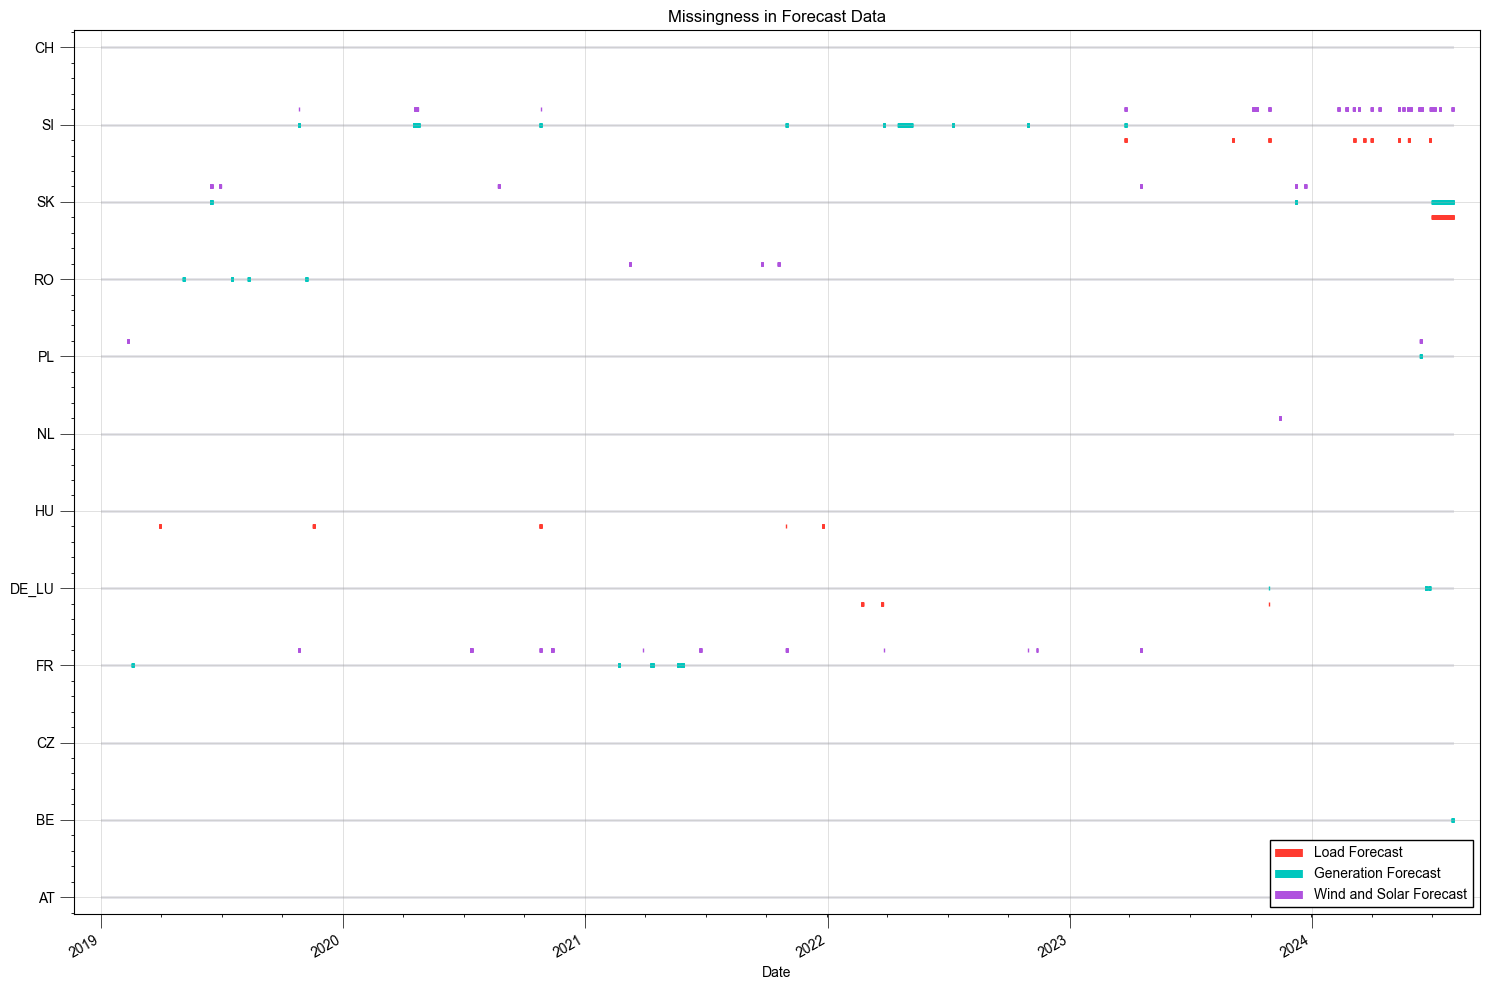

In [37]:
fig_combined = plot_combined_missingness('Missingness in Forecast Data')